In [10]:
from config import BASE_DIR
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tf.app import use
A = use("ETCBC/dss", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


You can see which features have been loaded, and if you click on a feature name, you find its documentation.
If you hover over a name, you see where the feature is located on your system.

In [4]:
from tqdm import tqdm
import re
import pandas as pd
import matplotlib.pyplot as plt
from notebooks.utils import chars_to_delete, get_biblical_from_line, remove_chars

def get_biblical_from_line(line):
    """
    Returns the biblical section of a line.
    """
    bib = F.biblical.v(line)
    if bib == None:
        return 'nonbib'
    elif bib == 1:
        return 'bib'
    elif bib == 2:
        return 'biblical_non_biblical'



In [11]:
import yaml
with open(f"{BASE_DIR}/data/yamls/all_sectarian_texts.yaml", "r") as f:
    all_sectarian_texts = yaml.load(f, Loader=yaml.FullLoader)
    all_sectarian_texts = {k: v for k, v in all_sectarian_texts.items() if len(v) > 0}
    


In [12]:
all_books_labeled = {"sectarian_texts": [], "non_sectarian_texts": [], "unknown": []}
flatten = []
for section in all_sectarian_texts.keys():
    for scroll in all_sectarian_texts[section].keys():
        for book in all_sectarian_texts[section][scroll]:
            # print(f"{section=}, {scroll=}, {book=}")
            flatten.append({"section": section, "scroll": scroll, "book": book})
            
        

In [13]:
books_with_label = pd.DataFrame(flatten)
relevant_books = books_with_label["book"].to_list()
books_with_label

,section,scroll,book
0,sectarian_texts,1QS,1QS
1,sectarian_texts,4QS,4Q255
2,sectarian_texts,4QS,4Q256
3,sectarian_texts,4QS,4Q257
4,sectarian_texts,4QS,4Q258
...,...,...,...
94,unknown,Shir Shabat,4Q406
95,unknown,Shir Shabat,4Q407
96,unknown,Temple Scroll,11Q19
97,unknown,Temple Scroll,11Q20


In [14]:
data = {}
books = {}
for line in tqdm(F.otype.s("line")[:]):
    book_and_chapter = A.sectionStrFromNode(line)
    book = A.sectionStrFromNode(line).split(" ")[0]
    if book not in relevant_books:
        continue
    text = book_and_chapter + "\t" + str(get_biblical_from_line(line)) + "\t"+ T.text(line)
    text = remove_chars(text).replace("\xa0", "").replace("׃",".")
    text = [text]
    
    if book not in data:
        data[book] = [text]
    else: 
        data[book].append(text)

100%|██████████| 52895/52895 [00:03<00:00, 16871.15it/s]


In [15]:
lst_for_df = []
for book in data.keys():
    for line in data[book]:
        line_splitted = line[0].split("\t")
        book = line_splitted[0].split(" ")[0]
        pasuk = line_splitted[0].split(" ")[1]
        bib_nonbib = line_splitted[1]
        text = line_splitted[2] 
        lst_for_df.append({"book": book, "pasuk": pasuk, "label": bib_nonbib, "text": text})
df = pd.DataFrame(lst_for_df)

In [16]:
assert len(relevant_books) == len(set(df["book"].unique()))

In [17]:
df = pd.merge(df,books_with_label, how="inner", on="book")
df = df.drop("label",axis=1)
df["label"] = df["section"]
df = df[df["label"] != "unknown"]


In [26]:

df["word_count"] = df["text"].str.split(" ").str.len()
book_stats = (
    df.groupby("book")["word_count"].agg(["sum", "count"]).sort_values(by="count")
)
book_stats.columns = ["word_count", "lines_count"]
label_stats = (
    df.groupby("label")["word_count"].agg(["sum", "count"]).sort_values(by="count")
)
label_stats.columns = ["word_count", "lines_count"]

Text(0.5, 1.0, 'Lines Count per label')

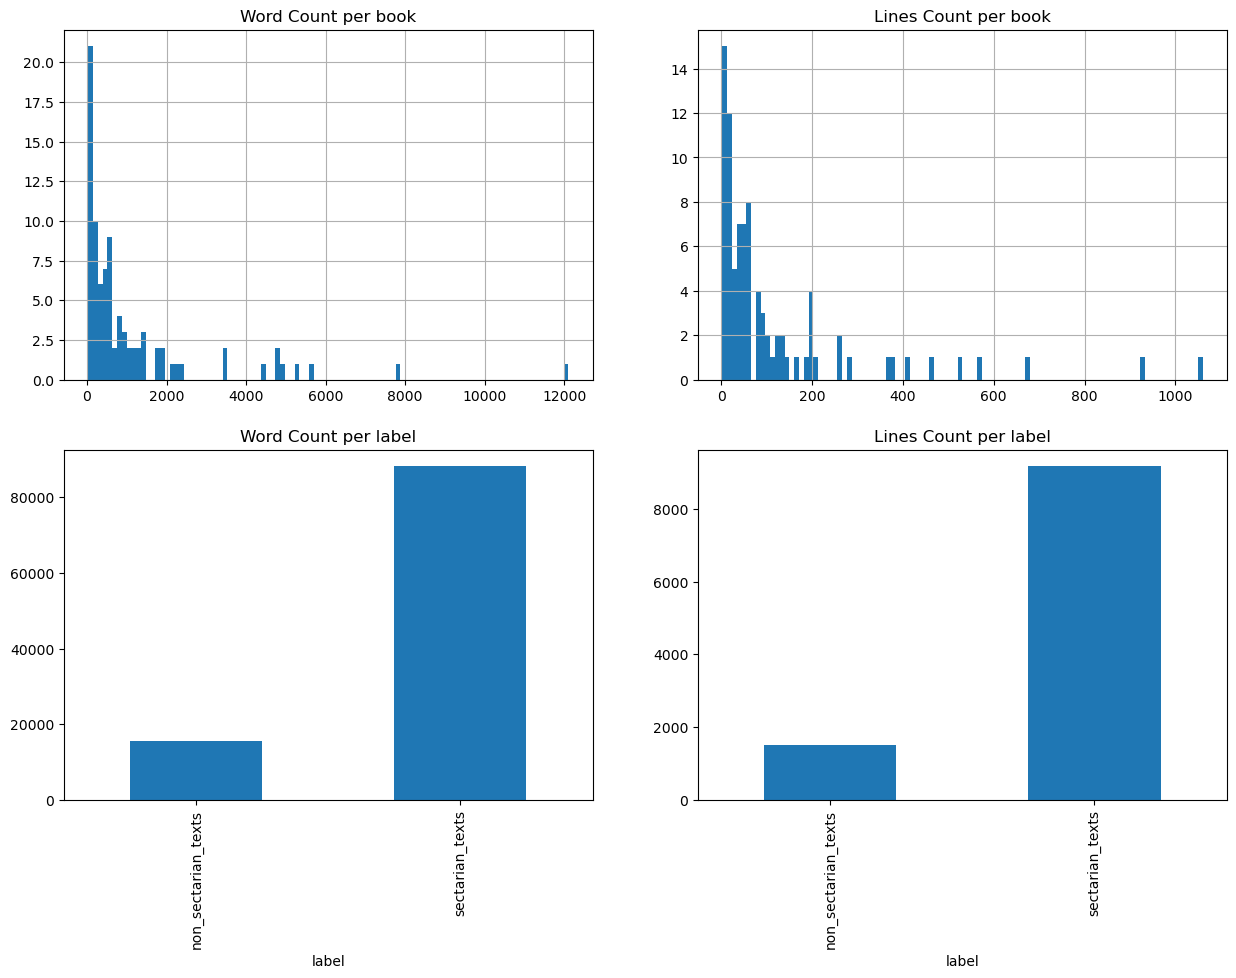

In [27]:

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
book_stats["word_count"].hist(bins=100,ax=ax[0,0])
book_stats["lines_count"].hist(bins=100,ax=ax[0,1])
label_stats["word_count"].plot(kind="bar",ax=ax[1,0])
label_stats["lines_count"].plot(kind="bar",ax=ax[1,1])
ax[0,0].set_title("Word Count per book")
ax[0,1].set_title("Lines Count per book")
ax[1,0].set_title("Word Count per label")
ax[1,1].set_title("Lines Count per label")

In [28]:

books_with_enough_data = book_stats[book_stats["word_count"]>=60].sort_values(by="word_count", ascending=False).index.to_list()
df_filtered = df[df["book"].isin(books_with_enough_data)]
df_filtered = df_filtered[df_filtered["label"]!="biblical_non_biblical"]


In [29]:
book_stats = (
    df_filtered.groupby("book")["word_count"].agg(["sum", "count"]).sort_values(by="count")
)
book_stats.columns = ["word_count", "lines_count"]
label_stats = (
    df_filtered.groupby("label")["word_count"].agg(["sum", "count"]).sort_values(by="count")
)
label_stats.columns = ["word_count", "lines_count"]

Text(0.5, 1.0, 'Lines Count per label')

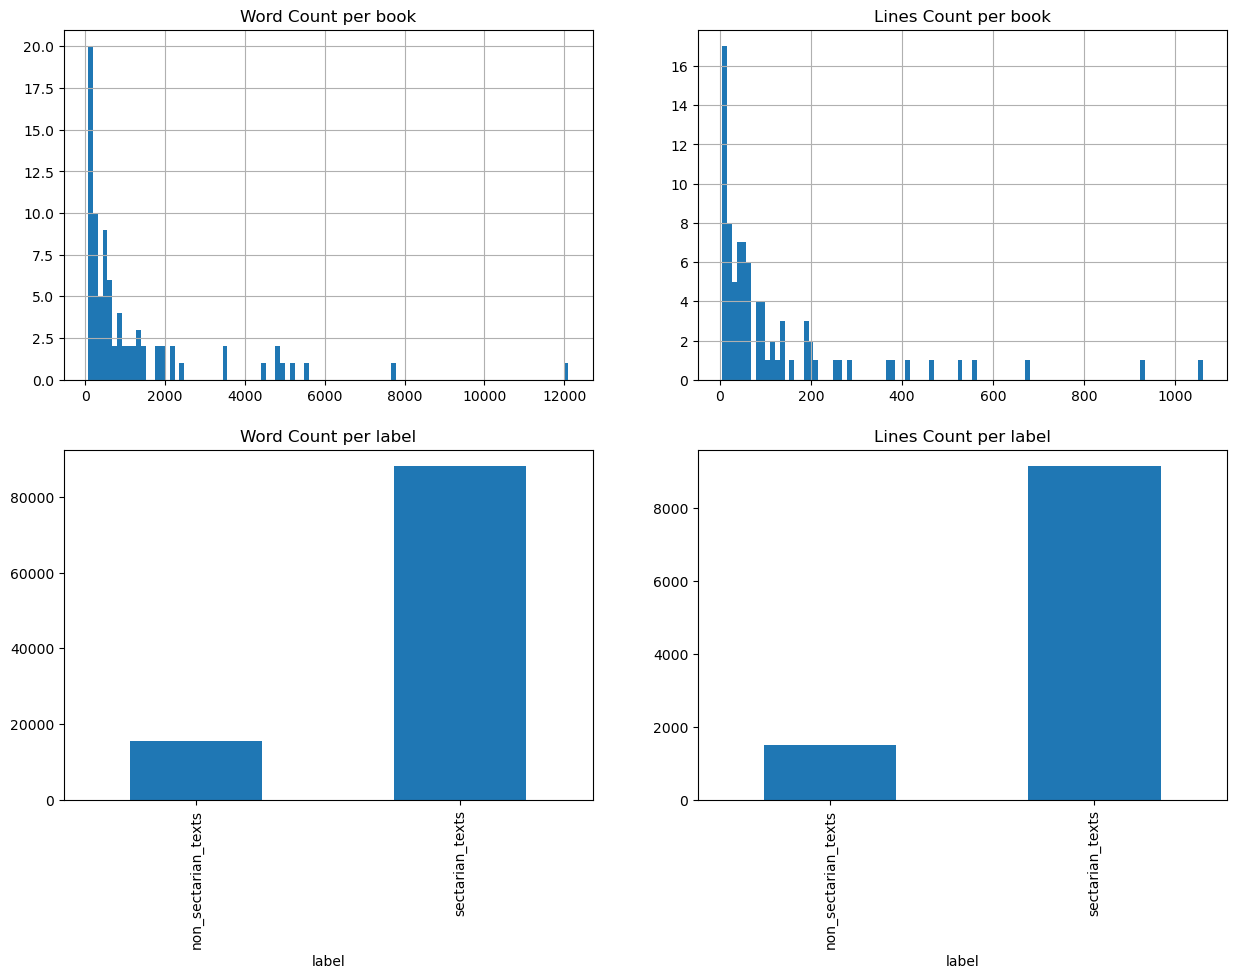

In [30]:

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
book_stats["word_count"].hist(bins=100,ax=ax[0,0])
book_stats["lines_count"].hist(bins=100,ax=ax[0,1])
label_stats["word_count"].plot(kind="bar",ax=ax[1,0])
label_stats["lines_count"].plot(kind="bar",ax=ax[1,1])
ax[0,0].set_title("Word Count per book")
ax[0,1].set_title("Lines Count per book")
ax[1,0].set_title("Word Count per label")
ax[1,1].set_title("Lines Count per label")

In [162]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_filtered, test_size=0.3, random_state=42, stratify=df_filtered["label"])
df_train["train_test"]="train"
df_test["train_test"]="test"
df_filtered = pd.concat([df_train, df_test])
df_filtered.groupby(["train_test","label"]).count()

book  pasuk  text  section  scroll  word_count  book_pasuk
train_test label                                                            
test       0       447    447   447      447     447         447         447
           1      2745   2745  2745     2745    2745        2745        2745
train      0      1043   1043  1043     1043    1043        1043        1043
           1      6405   6405  6405     6405    6405        6405        6405

In [164]:
df_filtered["book_pasuk"] = df_filtered["book"] + " " + df_filtered["pasuk"]

df_filtered[["book_pasuk", "train_test", "label"]].to_csv(
        f"DSS_sectarian_tf_labels.txt",
        sep="\t",
        index=False,
        header=False,
    )
df_filtered["text"].to_csv(
        f"DSS_sectarian_tf_text.txt", index=False, header=False
    )

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
df_filtered_origin = df_filtered.copy()
df_filtered["label"] = df_filtered["label"].map({"sectarian_texts": 1, "non_sectarian_texts": 0})
td = TfidfVectorizer(max_features = 4500)
X = df_filtered["text"]
y = df_filtered["label"]
X = td.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)


In [32]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score

import numpy as np


from sklearn.metrics import confusion_matrix


# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'MultinomialNB': MultinomialNB()
}

# Initialize a dictionary to hold accuracy scores
accuracy_scores = {}

# Train and evaluate each model
for name, model in tqdm(models.items()):
    if name == 'Deep Learning':
        # Fit deep learning model
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        # Predictions
        y_pred = model.predict(X_test).flatten()
        # Convert probabilities to binary predictions using 0.5 threshold
        y_pred = np.where(y_pred > 0.5, 1, 0)
    elif name == 'Linear Regression':
        # Fit linear regression model
        model.fit(X_train, y_train)
        # Predictions
        y_pred = model.predict(X_test)
        # Convert to binary predictions using 0.5 threshold
        y_pred = np.where(y_pred > 0.5, 1, 0)
    else:
        # Fit model
        model.fit(X_train, y_train)
        # Predictions
        y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy
    print(f"{name=}")
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    print(conf_matrix)

# Display the accuracy scores
results = []
for model_name, accuracy in accuracy_scores.items():
    print(f"{model_name}: {accuracy}")
    results.append((model_name, accuracy))


 20%|██        | 1/5 [00:01<00:07,  1.77s/it]

name='Logistic Regression'
              precision    recall  f1-score   support

           0       0.89      0.15      0.25       434
           1       0.88      1.00      0.94      2758

    accuracy                           0.88      3192
   macro avg       0.89      0.57      0.59      3192
weighted avg       0.88      0.88      0.84      3192


 40%|████      | 2/5 [00:51<01:30, 30.23s/it]

name='Linear Regression'
              precision    recall  f1-score   support

           0       0.27      0.38      0.32       434
           1       0.90      0.84      0.87      2758

    accuracy                           0.78      3192
   macro avg       0.59      0.61      0.59      3192
weighted avg       0.81      0.78      0.79      3192


 80%|████████  | 4/5 [03:50<00:59, 59.44s/it]

name='Random Forest'
              precision    recall  f1-score   support

           0       0.68      0.29      0.41       434
           1       0.90      0.98      0.94      2758

    accuracy                           0.89      3192
   macro avg       0.79      0.63      0.67      3192
weighted avg       0.87      0.89      0.86      3192

name='Naive Bayes'
              precision    recall  f1-score   support

           0       0.90      0.13      0.22       434
           1       0.88      1.00      0.93      2758

    accuracy                           0.88      3192
   macro avg       0.89      0.56      0.58      3192
weighted avg       0.88      0.88      0.84      3192


100%|██████████| 5/5 [03:51<00:00, 46.29s/it]

name='SVM'
              precision    recall  f1-score   support

           0       0.69      0.37      0.48       434
           1       0.91      0.97      0.94      2758

    accuracy                           0.89      3192
   macro avg       0.80      0.67      0.71      3192
weighted avg       0.88      0.89      0.88      3192

Logistic Regression: 0.881578947368421
Linear Regression: 0.7788220551378446
Random Forest: 0.8850250626566416
Naive Bayes: 0.8793859649122807
SVM: 0.8909774436090225


In [52]:

incorrect_predictions = y_test[y_test != y_pred]
incorrect_predictions = df_filtered.loc[incorrect_predictions.index]
incorrect_predictions.groupby("book")["label"].value_counts().sort_values(ascending=False)


book       label              
11Q5       non_sectarian_texts    116
4Q381      non_sectarian_texts    110
4Q223_224  non_sectarian_texts     54
4Q221      non_sectarian_texts     25
4Q216      non_sectarian_texts     18
11Q12      non_sectarian_texts     14
4Q217      non_sectarian_texts     12
4Q219      non_sectarian_texts      9
4Q222      non_sectarian_texts      8
4Q380      non_sectarian_texts      7
1Q18       non_sectarian_texts      3
1Q17       non_sectarian_texts      2
4Q174      sectarian_texts          1
4Q173      sectarian_texts          1
4Q220      non_sectarian_texts      1
4Q171      sectarian_texts          1
4Q266      sectarian_texts          1
4Q429      sectarian_texts          1
4Q511      sectarian_texts          1
Name: count, dtype: int64

In [66]:
df_filtered

,book,pasuk,text,word_count,section,scroll,label
0,CD,1:1,ועתה שמעו כל יודעי צדק ובינו במעשי,9,sectarian_texts,CD,sectarian_texts
1,CD,1:2,אל . כי ריב לו עם כל בשר ומשפט יעשה בכל מנאציו .,14,sectarian_texts,CD,sectarian_texts
2,CD,1:3,כי במועלם אשר עזבוהו הסתיר פניו מישראל וממקדשו,9,sectarian_texts,CD,sectarian_texts
3,CD,1:4,ויתנם לחרב . ובזכרו ברית ראשנים השאיר שאירית,9,sectarian_texts,CD,sectarian_texts
4,CD,1:5,לישראל ולא נתנם לכלה . ובקץ חרון שנים שלוש מאות,11,sectarian_texts,CD,sectarian_texts
...,...,...,...,...,...,...,...
11518,11Q12,f12:2,ה,4,non_sectarian_texts,Book_of_Jubilees,non_sectarian_texts
11519,11Q12,f12:3,ל .,5,non_sectarian_texts,Book_of_Jubilees,non_sectarian_texts
11520,11Q12,f13:1,ויו,4,non_sectarian_texts,Book_of_Jubilees,non_sectarian_texts
11521,11Q12,f13:2,פר א,5,non_sectarian_texts,Book_of_Jubilees,non_sectarian_texts


In [95]:
import nltk
# nltk.download('punkt')
text_by_book = df_filtered.groupby("book")["text"].apply(list).to_dict()
sample = text_by_book["CD"]
sample = "".join(sample)
# sample = df_filtered["text"][0]
tokens = nltk.word_tokenize(sample)
tokens_length = [len(token) for token in tokens]
tokens

['ועתה',
 'שמעו',
 'כל',
 'יודעי',
 'צדק',
 'ובינו',
 'במעשי',
 'אל',
 '.',
 'כי',
 'ריב',
 'לו',
 'עם',
 'כל',
 'בשר',
 'ומשפט',
 'יעשה',
 'בכל',
 'מנאציו',
 '.',
 'כי',
 'במועלם',
 'אשר',
 'עזבוהו',
 'הסתיר',
 'פניו',
 'מישראל',
 'וממקדשו',
 'ויתנם',
 'לחרב',
 '.',
 'ובזכרו',
 'ברית',
 'ראשנים',
 'השאיר',
 'שאירית',
 'לישראל',
 'ולא',
 'נתנם',
 'לכלה',
 '.',
 'ובקץ',
 'חרון',
 'שנים',
 'שלוש',
 'מאות',
 'ותשעים',
 'לתיתו',
 'אותם',
 'ביד',
 'נבוכדנאצר',
 'מלך',
 'בבל',
 'פקדם',
 '.',
 'ויצמח',
 'מישראל',
 'ומאהרן',
 'שורש',
 'מטעת',
 'לירוש',
 'את',
 'ארצו',
 'ולדשן',
 'בטוב',
 'אדמתו',
 '.',
 'ויבינו',
 'בעונם',
 'וידעו',
 'כי',
 'אנשים',
 'אשימים',
 'הם',
 '.',
 'ויהיו',
 'כעורים',
 'וכימגששים',
 'דרך',
 'שנים',
 'עשרים',
 '.',
 'ויבן',
 'אל',
 'אל',
 'מעשיהם',
 'כי',
 'בלב',
 'שלם',
 'דרשוהו',
 'ויקם',
 'להם',
 'מורה',
 'צדק',
 'להדריכם',
 'בדרך',
 'לבו',
 '.',
 'ויודע',
 'לדורות',
 'אחרונים',
 'את',
 'אשר',
 'עשה',
 'בדור',
 'אחרון',
 'בעדת',
 'בוגדים',
 'הם',
 'סרי',
 'דרך',
 '.

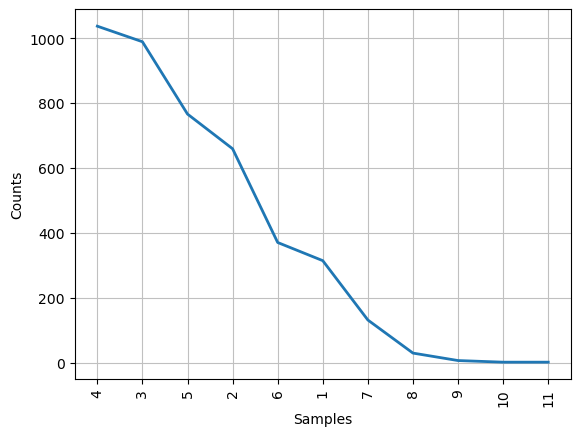

<Axes: xlabel='Samples', ylabel='Counts'>

In [96]:
nltk.FreqDist(tokens_length).plot()

In [146]:
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [149]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_filtered["text"].values.tolist()
# data
data_words = list(sent_to_words(data))
data_words
len(data_words)
# print(data_words[:1][0][:30])

10640

In [150]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [166]:
# df_filtered["section"].
from sklearn.preprocessing import LabelEncoder  

encoder = LabelEncoder()
encoder.fit_transform(df_filtered["section"])

array([1, 1, 0, ..., 1, 1, 1])

In [167]:
df_filtered["section"]

1385         sectarian_texts
8499         sectarian_texts
6474     non_sectarian_texts
11424    non_sectarian_texts
6448     non_sectarian_texts
                ...         
2567         sectarian_texts
1667         sectarian_texts
4235         sectarian_texts
10201        sectarian_texts
4324         sectarian_texts
Name: section, Length: 10640, dtype: object